### Segmenting and Clustering Neighborhoods in Toronto

Lets start with importing librarieswe will be working with

In [1]:
# Importing required libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
# We use BeautifulSoup as our scrapping tool. Lets import the bs library into our notebook
from bs4 import BeautifulSoup

In [4]:
#set max display width to none for pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# PART 1: Importing & Wrangling data from wiki 

### Obtain the table in the article which has data for 'Postcode', 'Borough', 'Neighbourhood'

In [5]:
#Set url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_data = requests.get(url).text #Request data from the url
html_parsed_result = BeautifulSoup(text_data, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# Extract required columns from the table ('Postcode', 'Borough', 'Neighbourhood')
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] 
    neightborhood_info.append(info)
    
neightborhood_info[0:15]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', 'Downtown Toronto', "Queen's Park"],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North']]

### Convert list of columns into pandas dataframe

In [6]:
#transforming list to dataframe
neightborhood_info[0][-1] = 'Neighborhood' 
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(11)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


### Process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned

In [7]:
#removing 'Not assigned' in the dataframe
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('We see the following counts:\n')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

DataFrame shape is (287, 3) 

We see the following counts:

  180 Postal codes
  10 Boroughs
  208 Neighborhoods
  77 rows with Not assigned Borough
  77 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



### Removing rows where Boroughs is "Not assigned"

In [8]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


### Replacing "Not assigned" values in the Neighborhood column with the Borough name in that cell

In [9]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Etobicoke,Islington Avenue
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


### New shape of the dataframe after cleaning

In [10]:
print('DataFrame shape:'.format(neighborhood_df.shape))
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

DataFrame shape:
There are:
  103 Postal codes
  10 Boroughs
  208 Neighborhoods


In [11]:
# Grouping dataframe by postal code
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']
grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [13]:
# shape of grouped dataframe
grouped_df.shape


(103, 3)

### Let's download csv file that has the geographical coordinates of each postal code. The link to the file is given in the project instructions in coursera.

In [14]:
!wget -q -O 'Geospatial_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


### Finding coordinates of the postal code neighborhoods


In [15]:
coordinates_df = pd.read_csv('Geospatial_data.csv') # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# PART 2: Used the Geocoder package or the csv file to create the following dataframe:

### Joining coordinates_df to neighborhood dataframe using the postcodes as keys

In [16]:
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')
postcodes_with_coordinates_df.head(12)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


### Identifying neighborhoods on map with the help of populated coordinates

In [17]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=10)

for location in postcodes_with_coordinates_df.itertuples():
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

# Find the closest points for each postcode to define the radius use with foursquare 

In [18]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [19]:
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]
X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]
distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


In [20]:
# New column 'Distance' is added to the DataFrame and is used as the radius cover for each postcode

from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


# PART 3: Explore and cluster the neighborhoods in Toronto

### Lets define client and secret IDS to communicate with Foursquare API

In [21]:
#Assigning IDs 
CLIENT_ID = 'your ID' #  Foursquare client ID
CLIENT_SECRET = 'your secret ID' # Foursquare Secret ID
VERSION = '20190229'

### Lets explore a maximum of 100 venues within a radius of 500 meters the first postcode in the data returned by the Foursquare API.

In [22]:
# Formatting url
first_postcode = postcodes_with_coordinates_df.iloc[2, :]
lat = first_postcode['Latitude']
lng = first_postcode['Longitude']
radius = 500
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)
url                                                                                                                   

'https://api.foursquare.com/v2/venues/explore?client_id=VA4YDYL2GG4RGKHEIYD3Z0AK1Y4BSX2M3VJFHP4XXW43P3CH&client_secret=GDMJU4L2U13HBN5MHCJNXG5C5XYY2VCXCRVL1TXP4TKFPYE3&ll=43.7635726,-79.1887115&v=20190229&radius=500&limit=100'

In [34]:
#Defining a function to format url, will be useful later

def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [35]:
#function to get details of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

# Making a request data from Foursquare API

In [25]:
#Display top rows 
venues_df = get_venues(url)
venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c62f34bde1b2d7fec89e370-0,"[{'id': '4bf58dd8d48988d122951735', 'name': 'E...",4c62f34bde1b2d7fec89e370,4371 kingston road,CA,Toronto,Canada,NaN,298,"[4371 kingston road, Toronto ON M1E 2M9, Canada]","[{'label': 'display', 'lat': 43.765309, 'lng':...",43.765309,-79.191537,M1E 2M9,ON,G & G Electronics,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-522deb21abdf65cfbab70655-1,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",522deb21abdf65cfbab70655,4379 Kingston Road,CA,Scarborough,Canada,NaN,326,"[4379 Kingston Road, Scarborough ON, Canada]","[{'label': 'display', 'lat': 43.766, 'lng': -7...",43.766000,-79.191000,NaN,ON,Marina Spa,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5411f741498e9ebd5e35d8bd-2,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",5411f741498e9ebd5e35d8bd,4383 Kingston rd.,CA,Scarborough,Canada,NaN,343,"[4383 Kingston rd., Scarborough ON, Canada]","[{'label': 'display', 'lat': 43.76629908447079...",43.766299,-79.190720,NaN,ON,Big Bite Burrito,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c1c7f9bb306c9288f0464b7-3,"[{'id': '4bf58dd8d48988d1ef941735', 'name': 'R...",4c1c7f9bb306c9288f0464b7,4304 Kingston Rd,CA,Scarborough,Canada,NaN,381,"[4304 Kingston Rd, Scarborough ON M1E 2M8, Can...","[{'label': 'display', 'lat': 43.7640757, 'lng'...",43.764076,-79.193406,M1E 2M8,ON,Enterprise Rent-A-Car,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b9008acf964a520737133e3-4,"[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",4b9008acf964a520737133e3,4125 Lawrence Ave E,CA,West Hill,Canada,Kingston Rd,445,"[4125 Lawrence Ave E (Kingston Rd), West Hill ...","[{'label': 'display', 'lat': 43.76663115313845...",43.766631,-79.192286,NaN,ON,Woburn Medical Centre,0,[]


# Clean & Extract dataframe to get venue.categories, venue.location.lat, venue.location.lng and venue.name

In [26]:
# function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 
venues_df = clean_df(venues_df)


In [27]:
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4bf58dd8d48988d122951735', 'name': 'E...",43.765309,-79.191537,G & G Electronics
1,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.766000,-79.191000,Marina Spa
2,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.766299,-79.190720,Big Bite Burrito
3,"[{'id': '4bf58dd8d48988d1ef941735', 'name': 'R...",43.764076,-79.193406,Enterprise Rent-A-Car
4,"[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",43.766631,-79.192286,Woburn Medical Centre


# Examining 'Category' column. We need to retrieve 'name' from this column which we use to classify our neighborhoods

In [28]:
venues_df.loc[0, 'Category']

[{'id': '4bf58dd8d48988d122951735',
  'name': 'Electronics Store',
  'pluralName': 'Electronics Stores',
  'shortName': 'Electronics',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/technology_',
   'suffix': '.png'},
  'primary': True}]

In [29]:
#function that extract the category 'name'
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

In [38]:
venues_df.head(20)

,Category,Lat,Lng,Name
0,Electronics Store,43.765309,-79.191537,G & G Electronics
1,Spa,43.766000,-79.191000,Marina Spa
2,Mexican Restaurant,43.766299,-79.190720,Big Bite Burrito
3,Rental Car Location,43.764076,-79.193406,Enterprise Rent-A-Car
4,Medical Center,43.766631,-79.192286,Woburn Medical Centre
5,Intersection,43.767704,-79.189490,Lawrence Ave E & Kingston Rd
6,Breakfast Spot,43.767800,-79.190466,Eggsmart


# Retrieving venue details

In [39]:
# function to construct the dataframe with all the venues (max 100 venues per postal code)

def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [40]:
all_venues = get_all_venues(postcodes_with_coordinates_df['Postcode'], postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df['Distance'])

print('The total number of venues returned: ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned:  3361


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
2,M1B,43.806686,-79.194353,Penguin Exhibit,43.819435,-79.185959,Zoo Exhibit
3,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
4,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
5,M1B,43.806686,-79.194353,Giraffe Exhibit,43.819851,-79.186692,Zoo Exhibit
6,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
7,M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
8,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
9,M1B,43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant


# Analyzing venues data

In [41]:
venues_in_postcode = all_venues.groupby('Postcode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['Postcode', '# of Venues']).set_index('Postcode').join(postcodes_with_coordinates_df[['Postcode','Distance']].set_index('Postcode'), on='Postcode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,Postcode,# of Venues,Distance
0,M1B,36,1698
1,M1C,10,1625
2,M1E,30,1205
3,M1G,5,913
4,M1H,22,913
5,M1J,24,1301
6,M1K,27,1112
7,M1L,29,1052
8,M1M,18,1112
9,M1N,14,1297


# Describe the dataframe to view statistical variables

In [42]:
venues_in_postcode.describe()

,# of Venues,Distance
count,103.000000,103.000000
mean,32.631068,883.349515
std,25.433107,401.737323
min,0.000000,75.000000
25%,13.500000,623.500000
50%,27.000000,912.000000
75%,45.000000,1112.000000
max,100.000000,1830.000000


# Lets build a histogram to see frequency of venues in each postal code

In [43]:
import matplotlib.pyplot as plt

venues_in_postcode['# of Venues'].hist(bins=5, figsize=(15,8),zorder=2, rwidth=0.9,color = 'pink')

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

<Figure size 1500x800 with 1 Axes>

#  K-means Clustering

Setting up k-means:
    
Now that we have our data, let's set up our k-means clustering.

The KMeans class has many parameters that can be used, but we will use these three:

__init__: Initialization method of the centroids.Value will be: "k-means++". 

__n_clusters__: The number of clusters to form as well as the number of centroids to generate.
Value will be: 5

__n_init__: Number of times the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
Value will be: 12

Initialize KMeans with these parameters, where the output parameter is called k_means.

In [44]:

k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12)


In [45]:
k_means.fit(venues_in_postcode['# of Venues'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[2 0 4 0 4 4 4 4 4 0 2 4 3 2 3 2 0 4 3 0 0 4 1 4 2 4 4 2 2 2 4 0 0 4 0 0 0
 3 2 4 4 3 4 1 0 0 4 2 0 3 0 3 3 3 3 4 4 4 1 0 0 2 0 0 4 4 1 4 0 0 2 4 0 4
 4 2 1 3 0 0 2 3 3 3 0 3 0 2 3 2 0 3 4 4 4 4 0 0 0 0 4 4 0]


In [46]:
venues_in_postcode['Cluster'] = k_means.labels_
venues_in_postcode.head(10)

,Postcode,# of Venues,Distance,Cluster
0,M1B,36,1698,2
1,M1C,10,1625,0
2,M1E,30,1205,4
3,M1G,5,913,0
4,M1H,22,913,4
5,M1J,24,1301,4
6,M1K,27,1112,4
7,M1L,29,1052,4
8,M1M,18,1112,4
9,M1N,14,1297,0


# Check the centroids values of postcodes per cluster

In [47]:
centroids = np.int64(round(venues_in_postcode.groupby('Cluster').mean()['# of Venues']))
frecuency = venues_in_postcode.groupby('Cluster').count()['Postcode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Postcodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Postcodes
0,0,8,32
1,4,25,33
2,2,41,16
3,3,66,17
4,1,99,5


# We can calssify postal codes into different clusters based on centroids


In [48]:
df = {'Category': ['Low Venues Density', 'Medium-Low Venues Density', 'Medium-High Venues Density', 'High Venues Density', 'Very High Venues Density'], \
     'Centroid': [8,25,41,66,99]}
df_final = pd.DataFrame(data=df, columns=['Category', 'Centroid'], index=None)
df_final

,Category,Centroid
0,Low Venues Density,8
1,Medium-Low Venues Density,25
2,Medium-High Venues Density,41
3,High Venues Density,66
4,Very High Venues Density,99


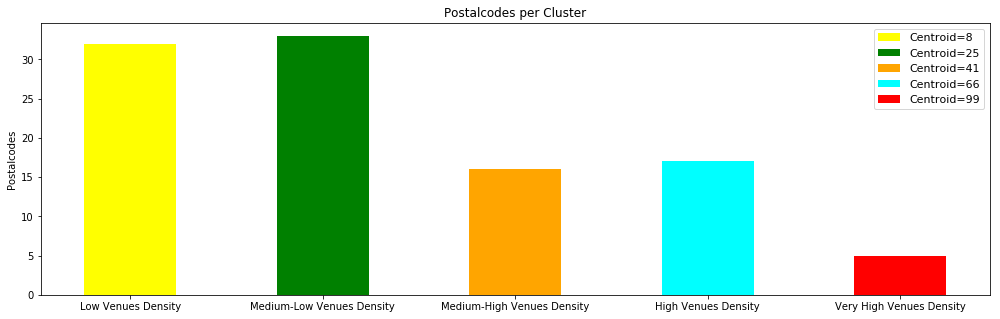

In [49]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['yellow','green','orange','cyan','red']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Postcodes'][id], 0.48, color=colors[id])

ax.set_ylabel('Postalcodes')
ax.set_title('Postalcodes per Cluster')

plt.legend(legend, fontsize=11)

plt.show()

# visualizing neighborhoods and how they cluster together.

In [50]:
postcodes_with_coordinates_df = pd.concat([postcodes_with_coordinates_df[:56],postcodes_with_coordinates_df[57:],postcodes_with_coordinates_df[56:57]]) #move M5E to the last row
postcodes_with_coordinates_df['Cluster'] = k_means.labels_

colors = ['yellow','green','orange','cyan','red']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in postcodes_with_coordinates_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map